# Histogram Based Outlier Detection with RobustScaler

This code template is for Anomaly detection/outlier analysis using the HBOS Algorithm implemented using the pyod library along with RobustScaler as a feature scaling technique.HBOS assumes feature independence and calculates the degree of outlyingness by building histograms. 

### Required Packages

In [ ]:
!pip install pyod

In [ ]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# from sklearn.manifold import Isomap
from pyod.models.hbos import HBOS
from sklearn.preprocessing import LabelEncoder,RobustScaler
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [ ]:
file_path = ''

List of features which are  required for model training .

In [ ]:
#x_values
features = []

In [ ]:
#y_value
target = ''

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [ ]:
df=pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [ ]:
X = df[features]
Y = df[target]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [ ]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)
def EncodeY(df):
    if len(df.unique())<=2:
        return df
    else:
        un_EncodedT=np.sort(pd.unique(df), axis=-1, kind='mergesort')
        df=LabelEncoder().fit_transform(df)
        EncodedT=[xi for xi in range(len(un_EncodedT))]
        print("Encoded Target: {} to {}".format(un_EncodedT,EncodedT))
        return df

Calling preprocessing functions on the feature set.


In [ ]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
Y=EncodeY(NullClearner(Y))
X.head()

Encoded Target: [0.         0.00243548 1.        ] to [0, 1, 2]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Data Rescaling
Robust Scaler
Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

The Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [ ]:
X_Scaled=RobustScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-2.164703,-0.509152,-0.107132,1.467283,0.675700,-0.023808,0.543873,0.307546,0.059898,0.348163,0.196576,-0.481315,-0.594156,-0.724810,-0.474130,0.970557,-0.519538,0.221744,0.118017,0.429006,0.811755,0.117050,0.428890,-0.232198,0.003663,-0.080926,-0.182817,0.852889,-0.536584,1.494759
1,-2.164703,0.663943,0.149093,-0.494971,0.150131,0.321139,0.063567,-0.004423,0.032220,-0.125877,-0.075831,0.876786,0.837788,0.339966,-0.276750,0.293813,0.387638,-0.148919,-0.098698,-0.119669,-0.130174,-0.489113,-0.669090,0.585285,-0.554859,-0.010838,0.314366,-0.125495,-0.099450,-0.296197
2,-2.164650,-0.508484,-1.065248,0.835404,0.111491,-0.166586,1.723688,0.848259,0.363178,-1.089883,0.320060,0.256681,-0.012300,0.504088,-0.302895,1.683932,-2.868928,1.257562,-0.034454,-2.231505,1.615764,0.895116,1.020513,3.704960,-1.034649,-0.908564,-0.103873,-0.443770,-1.009414,4.286568
3,-2.164650,-0.328229,-0.192138,0.851785,-0.591002,0.260239,1.235846,0.305596,0.627335,-0.992175,0.042553,-0.277309,0.083113,0.353388,-0.446721,-0.735972,-1.091667,-0.802666,2.128155,-1.204331,-0.538558,-0.145886,0.102358,-0.540437,-1.702355,0.860387,-0.234608,0.366684,0.471550,1.176377
4,-2.164596,-0.416481,0.611440,0.649524,0.124632,-0.083449,0.220759,0.653749,-0.691757,0.695687,0.896467,-0.651518,0.389377,0.956152,-1.427441,-0.080425,-0.501137,-0.289281,0.051718,0.827700,1.273557,0.142983,1.052379,-0.336368,0.105734,-0.687890,0.908440,1.442246,2.349435,0.524135


### Model

Histogram-based Outlier Score(HBOS): It is an unsupervised distance-based algorithm to capture the outliers. A suitable option for treating global outlier but not an impressive choice for local anomalies. When a data point is placed farther away from the rest of the data, then it is termed as a global outlier.
Whereas, the local oddity is a data point that lies in the limit of the entire data, but placed at a reasonable distance from its local neighbourhood. The algorithm assumes the features are completely independent(zero multicollinearity) of one another.

Refer [API](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos) for parameters

In [ ]:
model = HBOS(alpha=0.1, contamination=0.001, tol=0.5)
model.fit(X)

HBOS(alpha=0.1, contamination=0.001, n_bins=10, tol=0.5)

### Anomaly Prediction

In [ ]:
result = X_Scaled.copy(deep=True)
result['Anomaly']=model.predict(X_Scaled)
result.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Anomaly
0,-2.164703,-0.509152,-0.107132,1.467283,0.675700,-0.023808,0.543873,0.307546,0.059898,0.348163,0.196576,-0.481315,-0.594156,-0.724810,-0.474130,0.970557,-0.519538,0.221744,0.118017,0.429006,0.811755,0.117050,0.428890,-0.232198,0.003663,-0.080926,-0.182817,0.852889,-0.536584,1.494759,0
1,-2.164703,0.663943,0.149093,-0.494971,0.150131,0.321139,0.063567,-0.004423,0.032220,-0.125877,-0.075831,0.876786,0.837788,0.339966,-0.276750,0.293813,0.387638,-0.148919,-0.098698,-0.119669,-0.130174,-0.489113,-0.669090,0.585285,-0.554859,-0.010838,0.314366,-0.125495,-0.099450,-0.296197,0
2,-2.164650,-0.508484,-1.065248,0.835404,0.111491,-0.166586,1.723688,0.848259,0.363178,-1.089883,0.320060,0.256681,-0.012300,0.504088,-0.302895,1.683932,-2.868928,1.257562,-0.034454,-2.231505,1.615764,0.895116,1.020513,3.704960,-1.034649,-0.908564,-0.103873,-0.443770,-1.009414,4.286568,0
3,-2.164650,-0.328229,-0.192138,0.851785,-0.591002,0.260239,1.235846,0.305596,0.627335,-0.992175,0.042553,-0.277309,0.083113,0.353388,-0.446721,-0.735972,-1.091667,-0.802666,2.128155,-1.204331,-0.538558,-0.145886,0.102358,-0.540437,-1.702355,0.860387,-0.234608,0.366684,0.471550,1.176377,0
4,-2.164596,-0.416481,0.611440,0.649524,0.124632,-0.083449,0.220759,0.653749,-0.691757,0.695687,0.896467,-0.651518,0.389377,0.956152,-1.427441,-0.080425,-0.501137,-0.289281,0.051718,0.827700,1.273557,0.142983,1.052379,-0.336368,0.105734,-0.687890,0.908440,1.442246,2.349435,0.524135,0


### Anomaly Visualization

#### Bar Plot

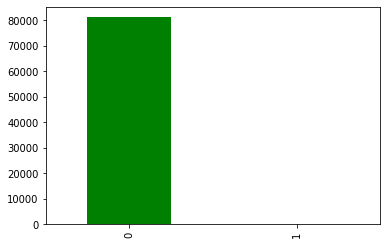

In [ ]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [ ]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate',)
fig.show()

#### Anomalies

In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [ ]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

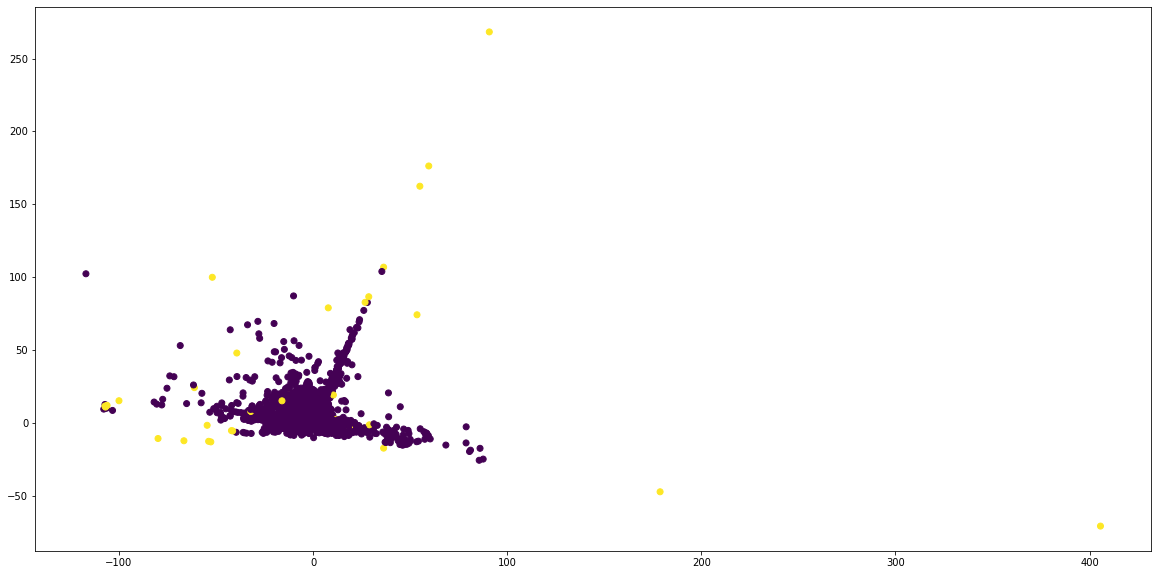

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Ageer Harikrishna , Github: [Profile](https://github.com/ageerHarikrishna)